### Import Packages


In [ ]:
import os
import csv
import numpy as np
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt

# Module for Google Drive
from google.colab import drive

# Module for Importing Images
from PIL import Image 

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset, SubsetRandomSampler

print(torch.__version__)

import math
from sklearn.model_selection import KFold

1.10.0+cu111


### Import your drive's contents!

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


### Let's define some path, and our PokeMon dataset
- Put the "pokemon" folder to somewhere of your Google Drive, and define the train/test path to "train_path" and "test_path"
- To 'model_dir', put the drive's directory path that you want to save your model

In [ ]:
train_path = './drive/MyDrive/Intro2DL/Asm1-Pokemon/pokemon-dataset/train' 
test_path = './drive/MyDrive/Intro2DL/Asm1-Pokemon/pokemon-dataset/test'
model_dir = './drive/MyDrive/Intro2DL/Asm1-Pokemon/'    #./drive/MyDrive/Path/To/Save/Your/Model
classes = ['bug', 'electric', 'fighting', 'fire', 'flying', 'grass', 'ground', 'phychic', 'poison', 'water']

In [ ]:
class PokemonDataset(Dataset):
    def __init__(self, data_path, classes):
        self.data_path = data_path
        self.classes = classes

        # organize path information for __len__ and __getitem__
        self.img_path_label = list()
        for c in self.classes:
            img_list = os.listdir(os.path.join(self.data_path, c))
            for fp in img_list:
                full_fp = os.path.join(self.data_path, c, fp)
                self.img_path_label.append((full_fp, c, self.classes.index(c)))

        # Add some tranforms for data augmentation.
        self.tensor_transform = torchvision.transforms.ToTensor()
        self.normalize_transform = torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                                    std=[0.229, 0.224, 0.225])

    def __len__(self):
        return len(self.img_path_label)

    def __getitem__(self, idx):
        (fp, class_name, class_label) = self.img_path_label[idx]
        img = Image.open(fp)
        original_img = self.tensor_transform(img)
        input = self.normalize_transform(original_img)

        sample = dict()
        sample['input'] = input
        sample['original_img'] = original_img
        sample['target'] = class_label
        sample['class_name'] = class_name

        return sample

### Set DataSet and DataLoader

In [ ]:
batch_size = 64

train_dataset = PokemonDataset(train_path, classes)
print(len(train_dataset))

# split into traning and validation data
# train_dataset_size = math.floor(len(train_dataset) * 8/10); # size of training : validation data = 8:2
# train_dataset , val_dataset = torch.utils.data.random_split(dataset=train_dataset, 
#                                                            lengths=[train_dataset_size,len(train_dataset) - train_dataset_size], 
#                                                            generator=torch.Generator().manual_seed(0))
test_dataset = PokemonDataset(test_path, classes)



train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
# test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(len(train_dataset))
print(len(test_dataset))

num_classes = len(classes)

2357
2357
60


### Take a sample and try to look at the one

In [ ]:
sample = next(iter(train_dataloader))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


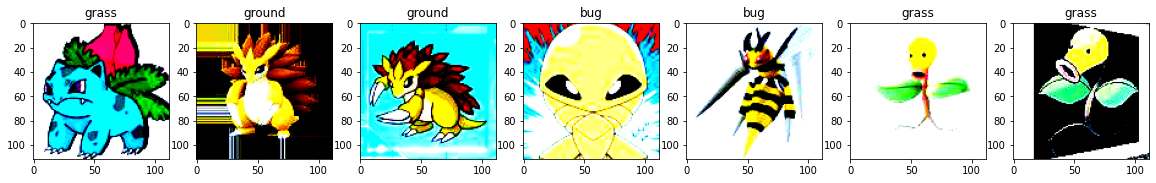

In [ ]:
fig, ax = plt.subplots(1, 7, figsize=(20, 10))
for i in range(7):
    ax[i].imshow(sample['input'][i].permute(1, 2, 0))
    ax[i].set_title(sample['class_name'][i])

### Choose your device - use GPU or not?

In [ ]:
# device = 'cpu'
device = 'cuda'
print('Current Device : {}'.format(device))

Current Device : cuda


### Define the model with the pre-trained ResNet

In [ ]:
class Model(nn.Module):
    def __init__(self, feat_dim = 2048, output_dim =num_classes):
        super(Model, self).__init__()

        self.feat_dim = feat_dim
        self.output_dim = output_dim

        self.backbone = torchvision.models.resnet50(pretrained=True)

        self.backbone.fc = nn.Linear(feat_dim, output_dim)

        # for param in self.backbone.conv1.parameters():
        #       param.requires_grad_(False)
        
        child_counter = 0
        for child in self.backbone.children():
            if child_counter < 3:
               print("child ",child_counter," was frozen")
               for param in child.parameters():
                     param.requires_grad = False
            else:
               print("child ",child_counter," was not frozen")
  
            child_counter += 1
              


    def forward(self, img):
        out = self.backbone(img) 
        return out


### Create a model and its optimizer


In [ ]:
model = Model()
model = model.to(device)

optimizer = optim.AdamW(model.parameters(), lr=1e-4)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

child  0  was frozen
child  1  was frozen
child  2  was frozen
child  3  was not frozen
child  4  was not frozen
child  5  was not frozen
child  6  was not frozen
child  7  was not frozen
child  8  was not frozen
child  9  was not frozen


In [ ]:
model(sample['input'].to(device)).shape

torch.Size([64, 10])

In [ ]:

# child_counter = 0
# for child in model.backbone.children():
#    print(" child", child_counter, "is:")
#    print(child)
#    child_counter += 1

for child in model.children():
   print(child)


# for param in model.backbone.conv1.parameters():
#     param.requires_grad_(False)

AttributeError: ignored

### Define functions for train/test



In [ ]:
def train(model, optimizer, sample):
    model.train()

    criterion = nn.CrossEntropyLoss()

    optimizer.zero_grad()

    input = sample['input'].float().to(device)
    target = sample['target'].long().to(device) 
    
    pred = model(input)
    pred_loss = criterion(pred, target)
    
    top_val, top_idx = torch.topk(pred, 1)

    num_correct = torch.sum(top_idx == target.view(-1, 1))
    
    pred_loss.backward()
       
    optimizer.step()

    return pred_loss.item(), num_correct.item()

In [ ]:
def test(model, sample):
    model.eval()

    criterion = nn.CrossEntropyLoss()

    with torch.no_grad():
        input = sample['input'].float().to(device)
        target = sample['target'].long().to(device) 

        pred = model(input)
        pred_loss = criterion(pred, target)

        top_val, top_idx = torch.topk(pred, 1)

        num_correct = torch.sum(top_idx == target.view(-1, 1))

    return pred_loss.item(), num_correct.item()

### Run Training

In [ ]:
max_epoch = 10  # was 10
save_stride = 5
tmp_path = './checkpoint.pth'
max_accu = -1

# Configuration options
k_folds = 5
num_epochs = 1
# loss_function = nn.CrossEntropyLoss()

# For fold results
results = {}

# Set fixed random number seed
torch.manual_seed(42)

# Define the K-fold Cross Validator
kfold = KFold(n_splits=k_folds, shuffle=True)

# Start print
print('--------------------------------')

# K-fold Cross Validation model evaluation
for fold, (train_ids, test_ids) in enumerate(kfold.split(train_dataset)):

  # Print
  print(f'FOLD {fold}')
  print('--------------------------------')

  # Sample elements randomly from a given list of ids, no replacement.
  train_subsampler = torch.utils.data.SubsetRandomSampler(train_ids)
  test_subsampler = torch.utils.data.SubsetRandomSampler(test_ids)

  # Define data loaders for training and testing data in this fold
  train_dataloader = torch.utils.data.DataLoader(
                      train_dataset, 
                      batch_size=10, sampler=train_subsampler)
  test_dataloader = torch.utils.data.DataLoader(
                      train_dataset,
                      batch_size=10, sampler=test_subsampler)


  for epoch in tqdm(range(max_epoch)):


    ###Train Phase

    
    
    # Initialize Loss and Accuracy
    train_loss = 0.0
    train_accu = 0.0

    # Load the saved MODEL AND OPTIMIZER after evaluation.
    if epoch > 0:
        checkpoint = torch.load(tmp_path)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        # how about learning rate scheduler?

    # Iterate over the train_dataloader
    with tqdm(total=len(train_dataloader)) as pbar:
        for idx, sample in enumerate(train_dataloader):
            curr_loss, num_correct = train(model, optimizer, sample)
            train_loss += curr_loss / len(train_dataloader)
            train_accu += num_correct / len(train_subsampler)
            pbar.update(1)

    # save the model and optimizer's information before the evaulation
    checkpoint = {
        'model' : Model(),
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
    }
    
    # Save the checkpoint - you can try to save the "best" model with the validation accuracy/loss
    torch.save(checkpoint, tmp_path)
    if (epoch+1) % save_stride == 0:
        torch.save(checkpoint, os.path.join(model_dir, 'pokemon_r50_{}.pth'.format(epoch+1)))
    torch.save(checkpoint, os.path.join(model_dir, 'pokemon_r50_recent.pth'))
    
    ### Test Phase
    # Initialize Loss and Accuracy
    test_loss = 0.0
    test_accu = 0.0

    # Iterate over the test_dataloader
    with tqdm(total=len(test_dataloader)) as pbar:
        for idx, sample in enumerate(test_dataloader):
            curr_loss, num_correct = test(model, sample)
            test_loss += curr_loss / len(test_dataloader)
            test_accu += num_correct / len(test_subsampler)
            pbar.update(1)


    max_accu = max(test_accu, max_accu)
    if max_accu == test_accu:
        # Save your best model to the checkpoint
        torch.save(checkpoint, os.path.join(model_dir, 'pokemon_r50_best.pth'))

    # These Lines would make you update your Google Drive after the saving.
    drive.flush_and_unmount()
    drive.mount('/content/drive')

    print(train_accu, test_accu)

--------------------------------
FOLD 0
--------------------------------


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/189 [00:00<?, ?it/s]

child  0  was frozen
child  1  was frozen
child  2  was frozen
child  3  was not frozen
child  4  was not frozen
child  5  was not frozen
child  6  was not frozen
child  7  was not frozen
child  8  was not frozen
child  9  was not frozen


  0%|          | 0/48 [00:00<?, ?it/s]

Mounted at /content/drive
0.9527851458885919 0.9894067796610158


  0%|          | 0/189 [00:00<?, ?it/s]

child  0  was frozen
child  1  was frozen
child  2  was frozen
child  3  was not frozen
child  4  was not frozen
child  5  was not frozen
child  6  was not frozen
child  7  was not frozen
child  8  was not frozen
child  9  was not frozen


  0%|          | 0/48 [00:00<?, ?it/s]

Mounted at /content/drive
0.9824933687002633 0.9957627118644057


  0%|          | 0/189 [00:00<?, ?it/s]

child  0  was frozen
child  1  was frozen
child  2  was frozen
child  3  was not frozen
child  4  was not frozen
child  5  was not frozen
child  6  was not frozen
child  7  was not frozen
child  8  was not frozen
child  9  was not frozen


  0%|          | 0/48 [00:00<?, ?it/s]

Mounted at /content/drive
0.9856763925729423 0.9978813559322022


  0%|          | 0/189 [00:00<?, ?it/s]

child  0  was frozen
child  1  was frozen
child  2  was frozen
child  3  was not frozen
child  4  was not frozen
child  5  was not frozen
child  6  was not frozen
child  7  was not frozen
child  8  was not frozen
child  9  was not frozen


  0%|          | 0/48 [00:00<?, ?it/s]

Mounted at /content/drive
0.9782493368700245 0.9957627118644057


  0%|          | 0/189 [00:00<?, ?it/s]

child  0  was frozen
child  1  was frozen
child  2  was frozen
child  3  was not frozen
child  4  was not frozen
child  5  was not frozen
child  6  was not frozen
child  7  was not frozen
child  8  was not frozen
child  9  was not frozen


  0%|          | 0/48 [00:00<?, ?it/s]

Mounted at /content/drive
0.9814323607427036 0.9978813559322022
FOLD 1
--------------------------------


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/189 [00:00<?, ?it/s]

child  0  was frozen
child  1  was frozen
child  2  was frozen
child  3  was not frozen
child  4  was not frozen
child  5  was not frozen
child  6  was not frozen
child  7  was not frozen
child  8  was not frozen
child  9  was not frozen


  0%|          | 0/48 [00:00<?, ?it/s]

Mounted at /content/drive
0.9803713527851439 0.9851694915254227


  0%|          | 0/189 [00:00<?, ?it/s]

child  0  was frozen
child  1  was frozen
child  2  was frozen
child  3  was not frozen
child  4  was not frozen
child  5  was not frozen
child  6  was not frozen
child  7  was not frozen
child  8  was not frozen
child  9  was not frozen


  0%|          | 0/48 [00:00<?, ?it/s]

Mounted at /content/drive
0.9755968169761252 0.9915254237288122


  0%|          | 0/189 [00:00<?, ?it/s]

child  0  was frozen
child  1  was frozen
child  2  was frozen
child  3  was not frozen
child  4  was not frozen
child  5  was not frozen
child  6  was not frozen
child  7  was not frozen
child  8  was not frozen
child  9  was not frozen


  0%|          | 0/48 [00:00<?, ?it/s]

Mounted at /content/drive
0.9846153846153827 0.9957627118644057


  0%|          | 0/189 [00:00<?, ?it/s]

child  0  was frozen
child  1  was frozen
child  2  was frozen
child  3  was not frozen
child  4  was not frozen
child  5  was not frozen
child  6  was not frozen
child  7  was not frozen
child  8  was not frozen
child  9  was not frozen


  0%|          | 0/48 [00:00<?, ?it/s]

Mounted at /content/drive
0.9909814323607409 0.993644067796609


  0%|          | 0/189 [00:00<?, ?it/s]

child  0  was frozen
child  1  was frozen
child  2  was frozen
child  3  was not frozen
child  4  was not frozen
child  5  was not frozen
child  6  was not frozen
child  7  was not frozen
child  8  was not frozen
child  9  was not frozen


  0%|          | 0/48 [00:00<?, ?it/s]

Mounted at /content/drive
0.9952254641909796 0.9978813559322022
FOLD 2
--------------------------------


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/189 [00:00<?, ?it/s]

child  0  was frozen
child  1  was frozen
child  2  was frozen
child  3  was not frozen
child  4  was not frozen
child  5  was not frozen
child  6  was not frozen
child  7  was not frozen
child  8  was not frozen
child  9  was not frozen


  0%|          | 0/48 [00:00<?, ?it/s]

Mounted at /content/drive
0.9925768822905595 0.9999999999999999


  0%|          | 0/189 [00:00<?, ?it/s]

child  0  was frozen
child  1  was frozen
child  2  was frozen
child  3  was not frozen
child  4  was not frozen
child  5  was not frozen
child  6  was not frozen
child  7  was not frozen
child  8  was not frozen
child  9  was not frozen


  0%|          | 0/48 [00:00<?, ?it/s]

Mounted at /content/drive
0.9909862142099656 0.9978768577494691


  0%|          | 0/189 [00:00<?, ?it/s]

child  0  was frozen
child  1  was frozen
child  2  was frozen
child  3  was not frozen
child  4  was not frozen
child  5  was not frozen
child  6  was not frozen
child  7  was not frozen
child  8  was not frozen
child  9  was not frozen


  0%|          | 0/48 [00:00<?, ?it/s]

Mounted at /content/drive
0.9809119830328717 0.9999999999999999


  0%|          | 0/189 [00:00<?, ?it/s]

child  0  was frozen
child  1  was frozen
child  2  was frozen
child  3  was not frozen
child  4  was not frozen
child  5  was not frozen
child  6  was not frozen
child  7  was not frozen
child  8  was not frozen
child  9  was not frozen


  0%|          | 0/48 [00:00<?, ?it/s]

Mounted at /content/drive
0.988335100742309 0.9978768577494691


  0%|          | 0/189 [00:00<?, ?it/s]

child  0  was frozen
child  1  was frozen
child  2  was frozen
child  3  was not frozen
child  4  was not frozen
child  5  was not frozen
child  6  was not frozen
child  7  was not frozen
child  8  was not frozen
child  9  was not frozen


  0%|          | 0/48 [00:00<?, ?it/s]

Mounted at /content/drive
0.9899257688229034 0.9999999999999999
FOLD 3
--------------------------------


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/189 [00:00<?, ?it/s]

child  0  was frozen
child  1  was frozen
child  2  was frozen
child  3  was not frozen
child  4  was not frozen
child  5  was not frozen
child  6  was not frozen
child  7  was not frozen
child  8  was not frozen
child  9  was not frozen


  0%|          | 0/48 [00:00<?, ?it/s]

Mounted at /content/drive
0.9862142099681843 0.9999999999999999


  0%|          | 0/189 [00:00<?, ?it/s]

child  0  was frozen
child  1  was frozen
child  2  was frozen
child  3  was not frozen
child  4  was not frozen
child  5  was not frozen
child  6  was not frozen
child  7  was not frozen
child  8  was not frozen
child  9  was not frozen


  0%|          | 0/48 [00:00<?, ?it/s]

Mounted at /content/drive
0.989395546129372 0.9999999999999999


  0%|          | 0/189 [00:00<?, ?it/s]

child  0  was frozen
child  1  was frozen
child  2  was frozen
child  3  was not frozen
child  4  was not frozen
child  5  was not frozen
child  6  was not frozen
child  7  was not frozen
child  8  was not frozen
child  9  was not frozen


  0%|          | 0/48 [00:00<?, ?it/s]

Mounted at /content/drive
0.9862142099681848 0.978768577494692


  0%|          | 0/189 [00:00<?, ?it/s]

child  0  was frozen
child  1  was frozen
child  2  was frozen
child  3  was not frozen
child  4  was not frozen
child  5  was not frozen
child  6  was not frozen
child  7  was not frozen
child  8  was not frozen
child  9  was not frozen


  0%|          | 0/48 [00:00<?, ?it/s]

Mounted at /content/drive
0.9777306468716848 0.9957537154989383


  0%|          | 0/189 [00:00<?, ?it/s]

child  0  was frozen
child  1  was frozen
child  2  was frozen
child  3  was not frozen
child  4  was not frozen
child  5  was not frozen
child  6  was not frozen
child  7  was not frozen
child  8  was not frozen
child  9  was not frozen


  0%|          | 0/48 [00:00<?, ?it/s]

Mounted at /content/drive
0.9772004241781524 0.9957537154989383
FOLD 4
--------------------------------


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/189 [00:00<?, ?it/s]

child  0  was frozen
child  1  was frozen
child  2  was frozen
child  3  was not frozen
child  4  was not frozen
child  5  was not frozen
child  6  was not frozen
child  7  was not frozen
child  8  was not frozen
child  9  was not frozen


  0%|          | 0/48 [00:00<?, ?it/s]

Mounted at /content/drive
0.9809119830328712 0.9999999999999999


  0%|          | 0/189 [00:00<?, ?it/s]

child  0  was frozen
child  1  was frozen
child  2  was frozen
child  3  was not frozen
child  4  was not frozen
child  5  was not frozen
child  6  was not frozen
child  7  was not frozen
child  8  was not frozen
child  9  was not frozen


  0%|          | 0/48 [00:00<?, ?it/s]

Mounted at /content/drive
0.9946977730646843 0.9978768577494691


  0%|          | 0/189 [00:00<?, ?it/s]

child  0  was frozen
child  1  was frozen
child  2  was frozen
child  3  was not frozen
child  4  was not frozen
child  5  was not frozen
child  6  was not frozen
child  7  was not frozen
child  8  was not frozen
child  9  was not frozen


  0%|          | 0/48 [00:00<?, ?it/s]

Mounted at /content/drive
0.9936373276776218 0.9978768577494691


  0%|          | 0/189 [00:00<?, ?it/s]

child  0  was frozen
child  1  was frozen
child  2  was frozen
child  3  was not frozen
child  4  was not frozen
child  5  was not frozen
child  6  was not frozen
child  7  was not frozen
child  8  was not frozen
child  9  was not frozen


  0%|          | 0/48 [00:00<?, ?it/s]

Mounted at /content/drive
0.9883351007423093 0.9999999999999999


  0%|          | 0/189 [00:00<?, ?it/s]

child  0  was frozen
child  1  was frozen
child  2  was frozen
child  3  was not frozen
child  4  was not frozen
child  5  was not frozen
child  6  was not frozen
child  7  was not frozen
child  8  was not frozen
child  9  was not frozen


  0%|          | 0/48 [00:00<?, ?it/s]

Mounted at /content/drive
0.9920466595970281 0.9978768577494691


In [ ]:
print(len(train_subsampler))

1885


In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from google.colab import drive
drive.flush_and_unmount()